In [1]:
# conda install -c conda-forge pyldavis

In [2]:
# in terminal
# python -m spacy download en_core_web_sm

In [3]:
# !conda install gensim -y

In [4]:
import spacy
import pickle
from emoji import UNICODE_EMOJI
import pyLDAvis

In [5]:
df = pickle.load(open("Data/clean_df.pickle","rb"))
single_defined_notes = pickle.load(open("Data/single_defined_notes.pickle","rb"))

Using a smaller set of notes to practice preprocessing

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import re
from sklearn.feature_extraction.text import TfidfVectorizer


In [7]:
import matplotlib.pyplot as plt

In [8]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join(feature_names[i] + ' ' + f'{topic[i]:9.2f}'
                        for i in topic.argsort()[:-no_top_words - 1:-1]))

# Topic Modeling

## single_defined_notes
### generate document-term matrix

https://stackoverflow.com/questions/57333183/sk-learn-countvectorizer-keeping-emojis-as-words

from sklearn.feature_extraction.text import TfidfVectorizer
s= ['👋 Welcome', '👋 Welcome']

v = TfidfVectorizer(token_pattern=r'[^\s]+')
v.fit(s)
v.get_feature_names()

['welcome', '👋']


In [9]:
vectorizer = CountVectorizer(token_pattern=r'[^\s]+',stop_words='english',min_df=200)
dtm = vectorizer.fit_transform(single_defined_notes)
dtm.shape

(286464, 660)

### LSA

In [10]:
# We have to convert `.toarray()` because the vectorizer returns a sparse matrix.
# For a big corpus, we would skip the dataframe and keep the output sparse.
dtm_lsa = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names())

In [11]:
dtm_lsa.columns

Index(['admission_tickets', 'airbnb', 'airplane', 'amazon',
       'american_football', 'april', 'artist_palette', 'ass', 'august',
       'automobile',
       ...
       '🥟', '🥤', '🥦', '🥩', '🥪', '🥯', '🥰', '🥳', '🦄', '🧀'],
      dtype='object', length=660)

In [12]:
# # Latent Semantic Analysis (LSA) is just another name for Singular Value Decomposition (SVD) applied to Natural Language Processing (NLP)

lsa = TruncatedSVD(150)
doc_topic = lsa.fit(dtm[:100000])

sum(lsa.explained_variance_ratio_[0:20])

0.42014827566833374

In [35]:
with open('Models/lsa_single_defined_100k.pickle', 'wb') as f:
    pickle.dump(doc_topic, f)

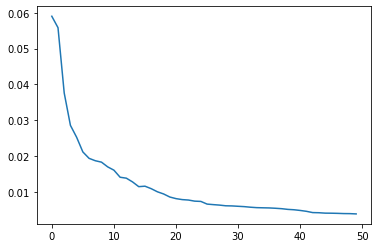

In [13]:
plt.plot(lsa.explained_variance_ratio_[0:50])

In [14]:
display_topics(lsa, vectorizer.get_feature_names(), 3)


Topic  0
️      0.60, ☕      0.56, hot_beverage      0.56

Topic  1
pizza      0.72, 🍕      0.69, hamburger      0.01

Topic  2
‍      0.47, man      0.36, 👨      0.36

Topic  3
money_with_wings      0.60, 💸      0.60, house      0.34

Topic  4
hamburger      0.70, 🍔      0.70, 🍟      0.04

Topic  5
taco      0.58, 🌮      0.56, burrito      0.39

Topic  6
☕      0.21, hot_beverage      0.21, taco      0.15

Topic  7
sushi      0.70, 🍣      0.69, taco      0.04

Topic  8
burrito      0.59, 🌯      0.58, sushi      0.06

Topic  9
american_football      0.70, 🏈      0.70, fantasy      0.07

Topic  10
red_heart      0.53, ❤      0.53, ️      0.26

Topic  11
🎉      0.65, party_popper      0.65, eggplant      0.18

Topic  12
party_popper      0.21, 🎉      0.21, house      0.09

Topic  13
light_skin_tone      0.37, 🏻      0.37, ❤      0.18

Topic  14
food      1.00, medium_light_skin_tone      0.03, 🏼      0.03

Topic  15
⚡      0.28, high_voltage      0.28, electric_plug      0.27

Topic  16

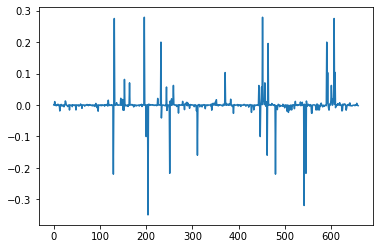

In [15]:
plt.plot(lsa.components_[15])

### NMF

In [16]:
nmf_model = NMF(20)
nmf_doc_topic = nmf_model.fit_transform(dtm[:100000])

In [36]:
with open('Models/nmf_single_defined_100k.pickle', 'wb') as f:
    pickle.dump(nmf_doc_topic, f)

In [17]:
display_topics(nmf_model, vectorizer.get_feature_names(), 3)


Topic  0
☕      6.60, hot_beverage      6.60, ️      6.14

Topic  1
pizza      7.76, 🍕      7.45, 🍗      0.03

Topic  2
‍      4.16, man      3.81, 👨      3.75

Topic  3
💸      5.34, money_with_wings      5.34, house      3.98

Topic  4
hamburger      6.23, 🍔      6.23, french_fries      0.32

Topic  5
taco      6.79, 🌮      6.58, tropical_drink      0.83

Topic  6
light_skin_tone      6.29, 🏻      6.29, ‍      2.51

Topic  7
sushi      5.83, 🍣      5.71, bento_box      0.10

Topic  8
burrito      5.35, 🌯      5.28, 🚙      0.08

Topic  9
american_football      5.68, 🏈      5.68, fantasy      0.58

Topic  10
❤      4.83, red_heart      4.83, ️      2.75

Topic  11
party_popper      5.56, 🎉      5.56, 🎂      0.65

Topic  12
eggplant      5.38, 🍆      5.38, peach      0.35

Topic  13
medium_light_skin_tone      4.99, 🏼      4.98, ‍      1.38

Topic  14
food      7.34, chinese      0.14, dog      0.11

Topic  15
⚡      2.84, high_voltage      2.84, electric_plug      2.26

Topic  16
wine_

## Gensim

In [18]:
from gensim import matutils, models
import scipy.sparse

/Users/allen/opt/anaconda3/envs/metis/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [19]:
tdm = dtm.transpose()

In [20]:
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [21]:
import gensim.corpora as corpora

In [22]:
id2word2 = corpora.Dictionary([[k for k,v in vectorizer.vocabulary_.items()]])

In [23]:
vectorizer.vocabulary_.items()

dict_items([('b', 12), ('food', 153), ('💇', 579), ('person_getting_haircut', 286), ('🎳', 531), ('bowling', 51), ('🍵', 507), ('teacup_without_handle', 380), ('good', 176), ('⛽', 457), ('fuel_pump', 164), ('🏿', 549), ('dark_skin_tone', 110), ('💃', 575), ('woman_dancing', 433), ('🌮', 472), ('taco', 374), ('🥑', 644), ('avocado', 10), ('know', 223), ('tickets', 392), ('🙏', 625), ('folded_hands', 152), ('🏼', 546), ('medium_light_skin_tone', 251), ('uber', 408), ('got', 178), ('ya', 437), ('cash', 69), ('money', 257), ('🔥', 609), ('🍗', 489), ('poultry_leg', 304), ('🐔', 550), ('chicken', 77), ('🎫', 529), ('ticket', 391), ('🍿', 516), ('popcorn', 301), ('airbnb', 1), ('🌶', 477), ('hot_pepper', 202), ('🏻', 545), ('light_skin_tone', 233), ('💯', 597), ('hundred_points', 207), ('💦', 593), ('sweat_droplets', 371), ('lunch', 241), ('\u200d', 444), ('♀', 449), ('female_sign', 145), ('🍸', 509), ('cocktail_glass', 89), ('🥰', 656), ('smiling_face_with_3_hearts', 345), ('🎂', 518), ('birthday_cake', 41), ('

In [24]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [25]:
from datetime import datetime

In [26]:
print(datetime.now().strftime("%H:%M:%S"))
lda = models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=20, passes=50, workers=8)
lda.print_topics()
print(datetime.now().strftime("%H:%M:%S"))

20:52:02
21:03:54


In [37]:
with open('Models/lda_single_defined_286k.pickle', 'wb') as f:
    pickle.dump(lda, f)

In [27]:
lda.print_topics()

[(0,
  '0.163*"money_with_wings" + 0.163*"💸" + 0.160*"house" + 0.136*"🏠" + 0.056*"two_hearts" + 0.056*"💕" + 0.025*"pile_of_poo" + 0.025*"💩" + 0.022*"trip" + 0.019*"💗"'),
 (1,
  '0.204*"taco" + 0.185*"🌮" + 0.043*"boy" + 0.035*"♥" + 0.035*"heart_suit" + 0.033*"👦" + 0.031*"sorry" + 0.030*"fee" + 0.029*"winking_face" + 0.029*"😉"'),
 (2,
  '0.065*"groceries" + 0.062*"chicken" + 0.060*"burrito" + 0.055*"🌯" + 0.044*"🐔" + 0.037*"thumbs_up" + 0.037*"👍" + 0.032*"tickets" + 0.031*"face_with_tears_of_joy" + 0.031*"😂"'),
 (3,
  '0.084*"automobile" + 0.084*"🚗" + 0.072*"lunch" + 0.042*"hair" + 0.039*"🎥" + 0.039*"movie_camera" + 0.036*"sparkles" + 0.036*"✨" + 0.033*"refund" + 0.032*"😷"'),
 (4,
  '0.062*"🥰" + 0.062*"smiling_face_with_3_hearts" + 0.056*"money_bag" + 0.056*"💰" + 0.044*"sandwich" + 0.037*"🥪" + 0.037*"🙌" + 0.037*"raising_hands" + 0.034*"wifi" + 0.031*"peach"'),
 (5,
  '0.092*"face_blowing_a_kiss" + 0.092*"😘" + 0.069*"love" + 0.058*"🍟" + 0.058*"french_fries" + 0.057*"poultry_leg" + 0.057*"🍗

In [28]:
from gensim.models import CoherenceModel

In [29]:
lda.log_perplexity(corpus)

-5.249840500069645

In [30]:
coherence_model_lda = CoherenceModel(model=lda, corpus=corpus, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -12.89004876596872


In [31]:
import pyLDAvis

In [32]:
import pyLDAvis.gensim

In [33]:
id2word

{12: 'b',
 153: 'food',
 579: '💇',
 286: 'person_getting_haircut',
 531: '🎳',
 51: 'bowling',
 507: '🍵',
 380: 'teacup_without_handle',
 176: 'good',
 457: '⛽',
 164: 'fuel_pump',
 549: '🏿',
 110: 'dark_skin_tone',
 575: '💃',
 433: 'woman_dancing',
 472: '🌮',
 374: 'taco',
 644: '🥑',
 10: 'avocado',
 223: 'know',
 392: 'tickets',
 625: '🙏',
 152: 'folded_hands',
 546: '🏼',
 251: 'medium_light_skin_tone',
 408: 'uber',
 178: 'got',
 437: 'ya',
 69: 'cash',
 257: 'money',
 609: '🔥',
 489: '🍗',
 304: 'poultry_leg',
 550: '🐔',
 77: 'chicken',
 529: '🎫',
 391: 'ticket',
 516: '🍿',
 301: 'popcorn',
 1: 'airbnb',
 477: '🌶',
 202: 'hot_pepper',
 545: '🏻',
 233: 'light_skin_tone',
 597: '💯',
 207: 'hundred_points',
 593: '💦',
 371: 'sweat_droplets',
 241: 'lunch',
 444: '\u200d',
 449: '♀',
 145: 'female_sign',
 509: '🍸',
 89: 'cocktail_glass',
 656: '🥰',
 345: 'smiling_face_with_3_hearts',
 518: '🎂',
 41: 'birthday_cake',
 523: '🎉',
 279: 'party_popper',
 473: '🌯',
 58: 'burrito',
 480: '🍆',
 

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, corpus, dictionary=id2word2)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16     0.317240  0.038737       1        1  8.637576
15    -0.075066 -0.029377       2        1  6.202503
12     0.159776 -0.079458       3        1  5.750233
0     -0.094848  0.342089       4        1  5.714991
13     0.307285  0.067537       5        1  5.687773
9     -0.067906 -0.036816       6        1  5.381647
10     0.065436 -0.070404       7        1  5.327236
5     -0.125407 -0.063940       8        1  4.924824
14    -0.023658  0.356315       9        1  4.791292
18    -0.080762 -0.040873      10        1  4.703551
11    -0.097791 -0.045619      11        1  4.547911
7     -0.071015 -0.035239      12        1  4.538269
2     -0.075828 -0.034572      13        1  4.495395
8      0.058519 -0.063866      14        1  4.471558
6     -0.076039 -0.054573      15        1  4.405961
19     0.056105 -0.079457      16        1  4.401294
17    -0.074426 -0.034304      17        1  4.297980
3     -0.076539 -0.032668      18        1  4.045718
1      0.049710 -0.074080      19        1  3.843009
4     -0.074787 -0.029431      20        1  3.831280, topic_info=               Term         Freq        Total Category  logprob  loglift
296           pizza  6592.000000  6592.000000  Default  30.0000  30.0000
153            food  6125.000000  6125.000000  Default  29.0000  29.0000
487               🍕  5541.000000  5541.000000  Default  28.0000  28.0000
462               ❤  5036.000000  5036.000000  Default  27.0000  27.0000
311       red_heart  5036.000000  5036.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
132  evergreen_tree   302.071045   302.989166  Topic20  -4.1136   3.2589
475               🌲   302.071045   302.989166  Topic20  -4.1136   3.2589
180           great   298.755615   299.673737  Topic20  -4.1246   3.2589
335        shipping   296.855682   297.773804  Topic20  -4.1310   3.2589
248           masks   280.652435   281.570557  Topic20  -4.1871   3.2587

[688 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
0        15  0.998563  admission_tickets
1         2  0.997329             airbnb
2         6  0.998600           airplane
3         8  0.997799             amazon
4        12  0.999672  american_football
...     ...       ...                ...
656      20  0.998842                  🥰
657      17  0.999173                  🥳
658      20  0.995710                  🦄
659      10  0.863734                  🧀
659      12  0.134802                  🧀

[641 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 16, 13, 1, 14, 10, 11, 6, 15, 19, 12, 8, 3, 9, 7, 20, 18, 4, 2, 5])

In [38]:
with open('Models/ldavis_single_defined_286k.pickle', 'wb') as f:
    pickle.dump(LDAvis_prepared, f)